# Import & IO


In [1]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import math
import time

In [2]:
def imOpen(imageFileName):
    buffer = BytesIO()
    imageFile = open(imageFileName, 'rb')
    buffer.write(imageFile.read())
    buffer.seek(0)
    imageFile.close()

    originalImage = Image.open(buffer)

    width = originalImage.size[0]
    height = originalImage.size[1]
    image = Image.new('L', (width,height))
    for x in range(0, width):
        for y in range(0, height):
            r, g, b = originalImage.getpixel((x, y))
            color = 0.3 * r + 0.59 * g + 0.11 * b
            image.putpixel((x, y), int(color))
    
    return image

In [3]:
def displayImage(image):
  plt.imshow(image, cmap="gray")

In [4]:
def convertImageToArray(image):
  pixels = list(image.getdata())
  width, height = image.size
  pixels = list(image.getdata())
  return [[pixels[i * width + j] for j in range(width)] for i in range(height)]

# Integral Image and Local Sum Calculation

In [5]:
def CalculateIntegral(imageArray):
  n = len(imageArray)
  m = len(imageArray[0])
  ii = [[0 for j in range(m)] for i in range(n)]
  for i in range(n):
    for j in range(m):
      cell = imageArray[i][j]
      if i > 0:
        cell += ii[i - 1][j]
      if j > 0:
        cell += ii[i][j - 1]
      if i > 0 and j > 0:
        cell -= ii[i - 1][j - 1]
      ii[i][j] = cell
  return ii

In [6]:
def CalculateLocalSum(ii, p0, p1):
  endPointRow, endPointCol = p1[0], p1[1]
  startPointRow, startPointCol = p0[0], p0[1]

  sum = ii[endPointRow][endPointCol]

  if startPointRow > 0:
    sum -= ii[startPointRow - 1][endPointCol]

  if startPointCol > 0:
    sum -= ii[endPointRow][startPointCol - 1]

  if startPointRow > 0 and startPointCol > 0:
    sum += ii[startPointRow - 1][startPointCol - 1]

  return sum

# Kernel Convolution

In [7]:
def prewittKernal(x, y, ii, kernalSize):
  midStep = kernalSize // 2
  
  h1Upper = CalculateLocalSum(ii, (y - midStep, x - midStep), (y - 1, x + midStep))
  h1Lower = CalculateLocalSum(ii, (y + 1, x - midStep), (y + midStep, x + midStep))
  h1 = h1Upper - h1Lower

  h2Left = CalculateLocalSum(ii, (y - midStep, x - midStep), (y + midStep, x - 1))
  h2Right = CalculateLocalSum(ii, (y - midStep, x + 1), (y + midStep, x + midStep))
  h2 = h2Right - h2Left

  return math.sqrt(h1 ** 2 + h2 ** 2)

def laplaceKernal(x, y, ii, kernalSize):
  midStep = kernalSize // 2

  allSum = CalculateLocalSum(ii, (y - midStep, x - midStep), (y + midStep, x + midStep))
  middle = CalculateLocalSum(ii, (y, x), (y, x))

  result = -allSum + middle + middle * (kernalSize ** 2 - 1)

  return abs(result)

def meanKernal(x, y, ii, kernalSize):
  midStep = kernalSize // 2

  sum = CalculateLocalSum(ii, (y - midStep, x - midStep), (y + midStep, x + midStep))
  
  return sum // (kernalSize ** 2)

In [8]:
def EdgeDetect(ii, kernalSize):
  width = len(ii[0])
  height = len(ii)
  prewitt = [[0 for x in range(width)] for y in range(height)]
  laplace = [[0 for x in range(width)] for y in range(height)]
  midStep = kernalSize // 2
  for y in range(midStep, height - midStep):
    for x in range(midStep, width - midStep):
      prewitt[y][x] = prewittKernal(x, y, ii, kernalSize)
      laplace[y][x] = laplaceKernal(x, y, ii, kernalSize)
  return prewitt, laplace

In [9]:
def RefineEdge(ii, kernalSize, ratio):
  width = len(ii[0])
  height = len(ii)
  refined = [[0 for x in range(width)] for y in range(height)]
  midStep = kernalSize // 2
  for y in range(midStep, height - midStep):
    for x in range(midStep, width - midStep):
      meanAverage = meanKernal(x, y, ii, kernalSize)
      pixelValue = CalculateLocalSum(ii, (y, x), (y, x))
      if pixelValue > meanAverage * ratio:
        refined[y][x] = pixelValue
      else:
        refined[y][x] = 0
  return refined

# Test Runs

In [10]:
def runWithStopwatch(callback, args, actionText):
  startTime = time.time()
  res = callback(*args)
  endTime = time.time()
  print(actionText + f' (Done in {int((endTime - startTime) * 1000)} ms)')
  return res

In [11]:
def testRun(ii, kernalSize):
    print(f'Calculating first and second derivatives of image for kernal size {kernalSize}...')
    d1, d2 = runWithStopwatch(EdgeDetect, [ii, kernalSize], 'Finished image first and second derivatives')
    print()

    print(f'Calculating first and second derivative integrals for kernal size {kernalSize}...')
    iiD1 = runWithStopwatch(CalculateIntegral, [d1], 'Finished first derivative integeral')
    iiD2 = runWithStopwatch(CalculateIntegral, [d1], 'Finished second derivative integeral')
    print()

    ratios = [1, 1.05, 1.15, 1.25]

    fig = plt.figure(figsize=(16, 24))
    rows = len(ratios) + 1
    columns = 2

    fig.add_subplot(rows, columns, 1)
    plt.title(f'first der. kernel {kernalSize} without refinement') 
    plt.imshow(d1, cmap="gray")

    fig.add_subplot(rows, columns, 2)
    plt.title(f'second der. kernel {kernalSize} without refinement') 
    plt.imshow(d2, cmap="gray")

    i = 3
    for r in ratios:
        print(f'Calculating refined first and second derivatives of kernal size {kernalSize} with ratio {r}...')
        iiD1R = runWithStopwatch(RefineEdge, [iiD1, 51, r], 'Finished refined first derivative')
        iiD2R = runWithStopwatch(RefineEdge, [iiD2, 51, r], 'Finished refined second derivative')
        print()

        fig.add_subplot(rows, columns, i)
        plt.title(f'first der. kernel {kernalSize} refined ratio {r}') 
        plt.imshow(iiD1R, cmap="gray")

        fig.add_subplot(rows, columns, i + 1)
        plt.title(f'second der. kernel {kernalSize} refined ratio {r}') 
        plt.imshow(iiD2R, cmap="gray")

        i += 2

    plt.show()

# Loading images and calculating their integrals

In [12]:
# Load images
l4 = imOpen("inputs/L4.jpg")
l4b = imOpen("inputs/L4b.jpg")

In [13]:
# Calculate integral image for both images
print(f'Calculating first and second images integrals...')
iiL4 = runWithStopwatch(CalculateIntegral, [convertImageToArray(l4)], 'Finished L4 image integeral')
iiL4b = runWithStopwatch(CalculateIntegral, [convertImageToArray(l4b)], 'Finished L4b image integeral')

Calculating first and second images integrals...
Finished L4 image integeral (Done in 4344 ms)
Finished L4b image integeral (Done in 4204 ms)


# Plotting results of image L4

First and second derivatives (of image L4) for different kernel sizes and different ratios

### Plotting all different refined edges ratios with kernel size 11

Calculating first and second derivatives of image for kernal size 11...
Finished image first and second derivatives (Done in 47809 ms)

Calculating first and second derivative integrals for kernal size 11...
Finished first derivative integeral (Done in 4098 ms)
Finished second derivative integeral (Done in 4017 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1...
Finished refined first derivative (Done in 15672 ms)
Finished refined second derivative (Done in 15503 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1.05...
Finished refined first derivative (Done in 15744 ms)
Finished refined second derivative (Done in 15355 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1.15...
Finished refined first derivative (Done in 15548 ms)
Finished refined second derivative (Done in 15335 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1.25...
Finished refined 

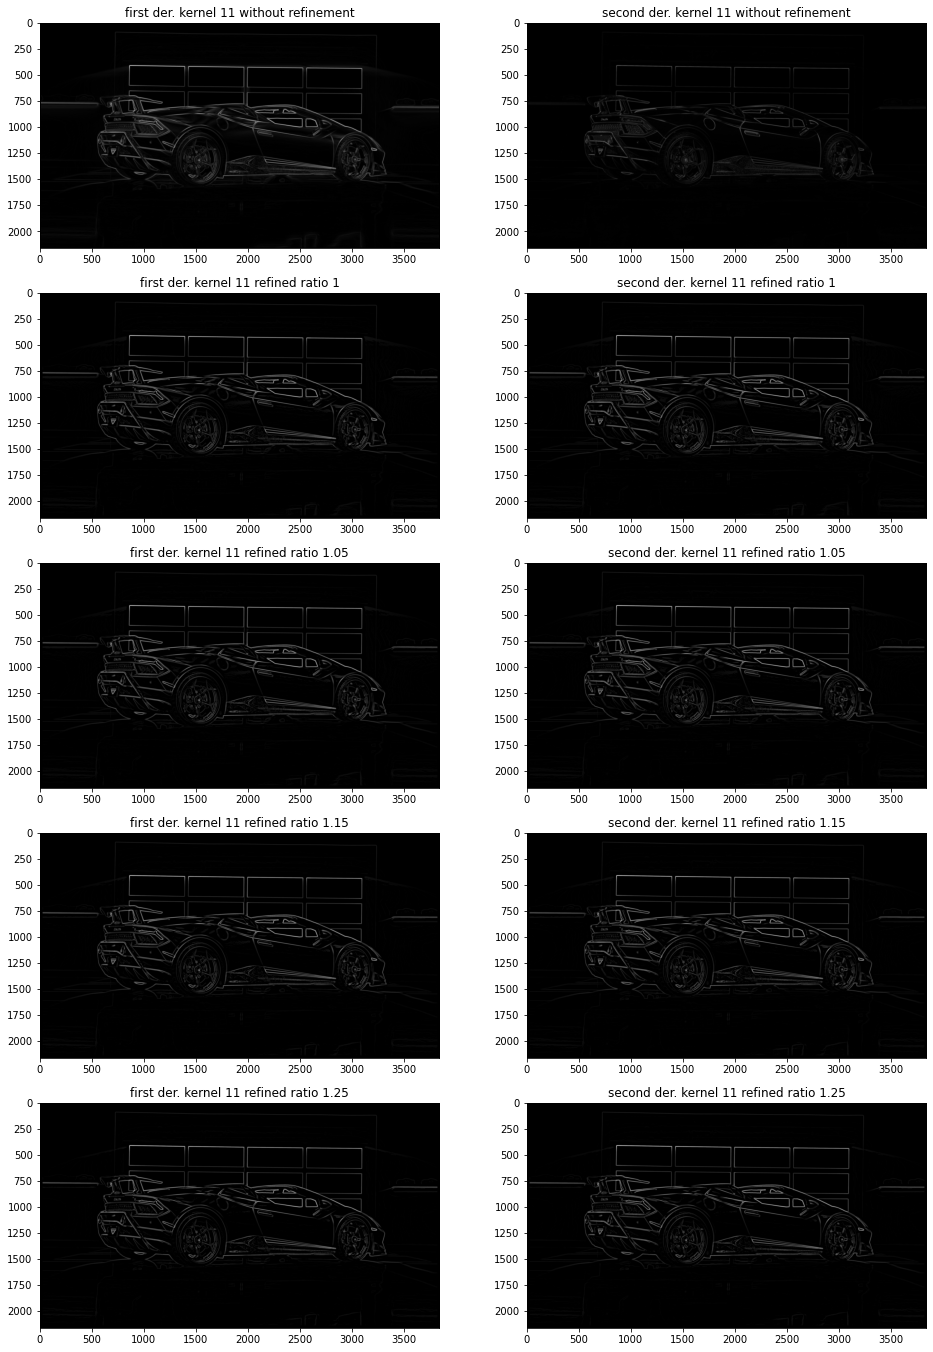

In [14]:
testRun(iiL4, 11)

### Plotting all different refined edges ratios with kernel size 51

Calculating first and second derivatives of image for kernal size 51...
Finished image first and second derivatives (Done in 47102 ms)

Calculating first and second derivative integrals for kernal size 51...
Finished first derivative integeral (Done in 4188 ms)
Finished second derivative integeral (Done in 4260 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1...
Finished refined first derivative (Done in 15823 ms)
Finished refined second derivative (Done in 15773 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1.05...
Finished refined first derivative (Done in 15575 ms)
Finished refined second derivative (Done in 15598 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1.15...
Finished refined first derivative (Done in 15675 ms)
Finished refined second derivative (Done in 15481 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1.25...
Finished refined 

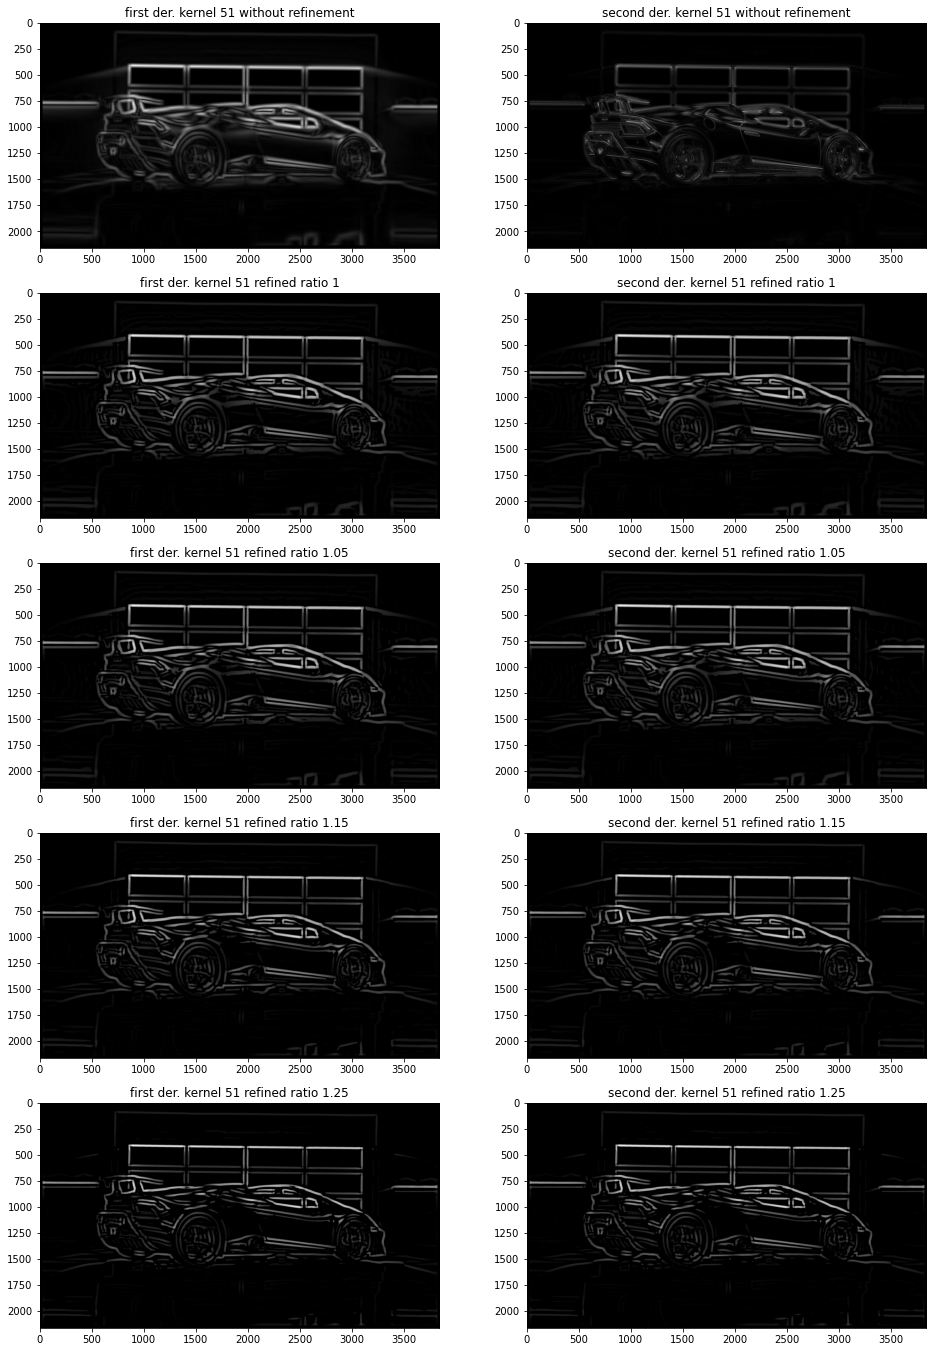

In [15]:
testRun(iiL4, 51)

### Plotting all different refined edges ratios with kernel size 101

Calculating first and second derivatives of image for kernal size 101...
Finished image first and second derivatives (Done in 45919 ms)

Calculating first and second derivative integrals for kernal size 101...
Finished first derivative integeral (Done in 3972 ms)
Finished second derivative integeral (Done in 4260 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1...
Finished refined first derivative (Done in 15860 ms)
Finished refined second derivative (Done in 15762 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1.05...
Finished refined first derivative (Done in 15627 ms)
Finished refined second derivative (Done in 15906 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1.15...
Finished refined first derivative (Done in 16008 ms)
Finished refined second derivative (Done in 15781 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1.25...
Finished re

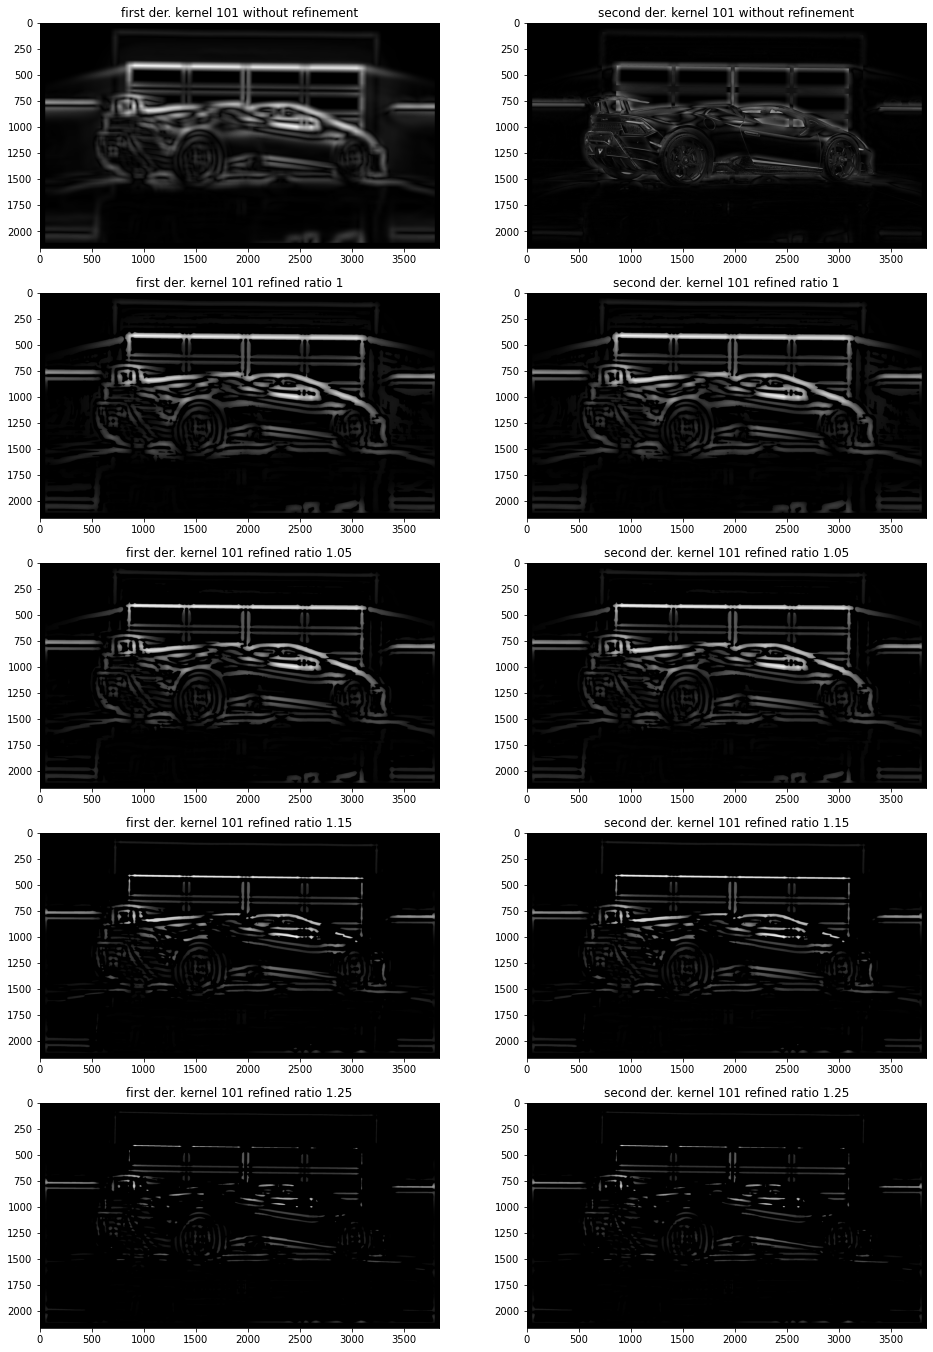

In [16]:
testRun(iiL4, 101)

### Plotting all different refined edges ratios with kernel size 121

Calculating first and second derivatives of image for kernal size 121...
Finished image first and second derivatives (Done in 45340 ms)

Calculating first and second derivative integrals for kernal size 121...
Finished first derivative integeral (Done in 3990 ms)
Finished second derivative integeral (Done in 4260 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1...
Finished refined first derivative (Done in 16069 ms)
Finished refined second derivative (Done in 15861 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1.05...
Finished refined first derivative (Done in 15869 ms)
Finished refined second derivative (Done in 15897 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1.15...
Finished refined first derivative (Done in 15697 ms)
Finished refined second derivative (Done in 15575 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1.25...
Finished re

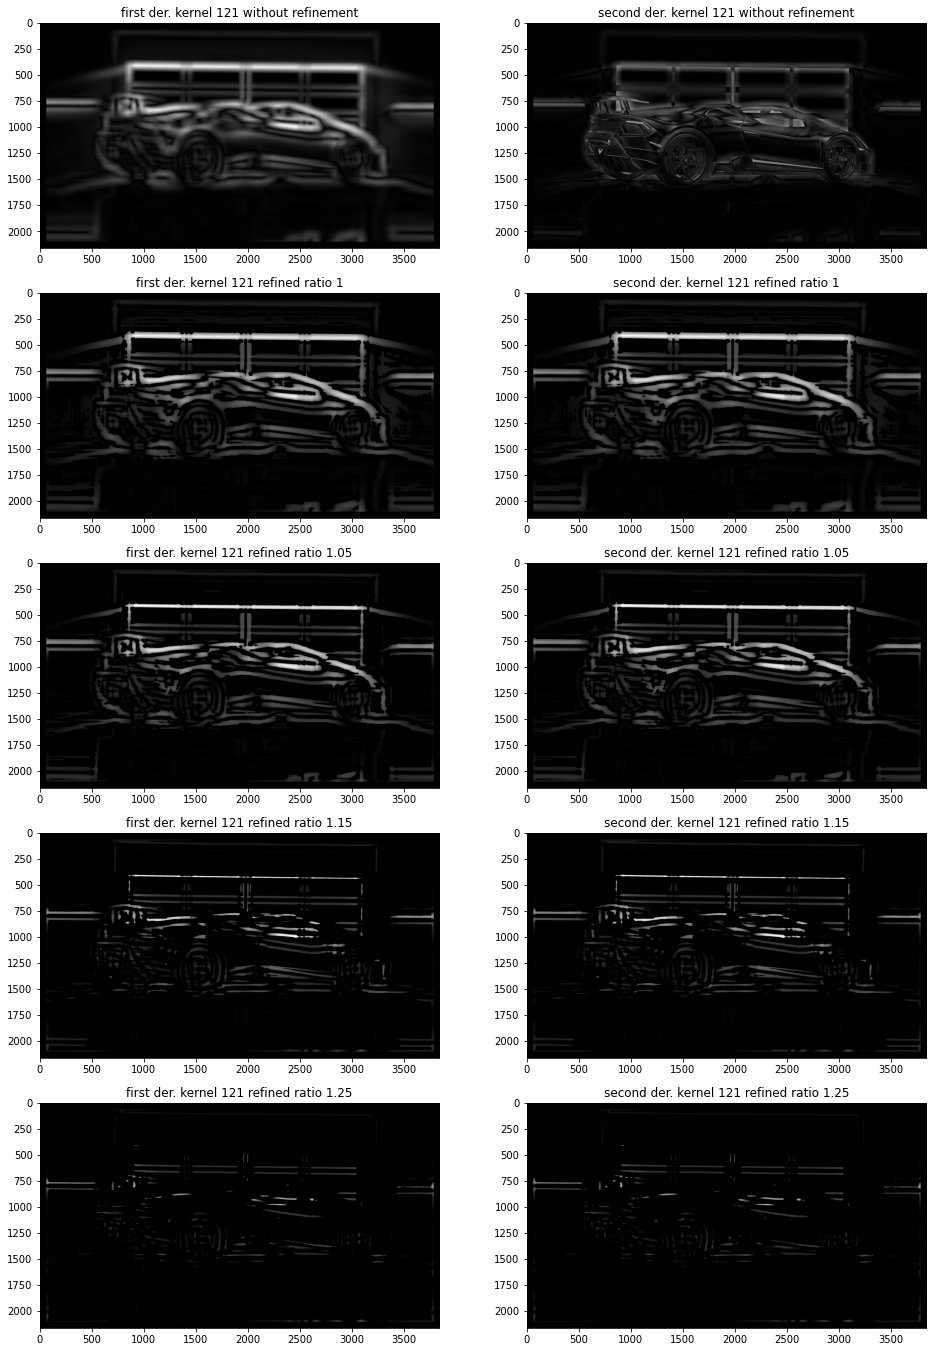

In [17]:
testRun(iiL4, 121)

# Plotting results of image L4B

First and second derivatives (of image L4b) for different kernel sizes and different ratios

### Plotting all different refined edges ratios with kernel size 11

Calculating first and second derivatives of image for kernal size 11...
Finished image first and second derivatives (Done in 47801 ms)

Calculating first and second derivative integrals for kernal size 11...
Finished first derivative integeral (Done in 4025 ms)
Finished second derivative integeral (Done in 4016 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1...
Finished refined first derivative (Done in 15622 ms)
Finished refined second derivative (Done in 15521 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1.05...
Finished refined first derivative (Done in 15410 ms)
Finished refined second derivative (Done in 15378 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1.15...
Finished refined first derivative (Done in 15496 ms)
Finished refined second derivative (Done in 15510 ms)

Calculating refined first and second derivatives of kernal size 11 with ratio 1.25...
Finished refined 

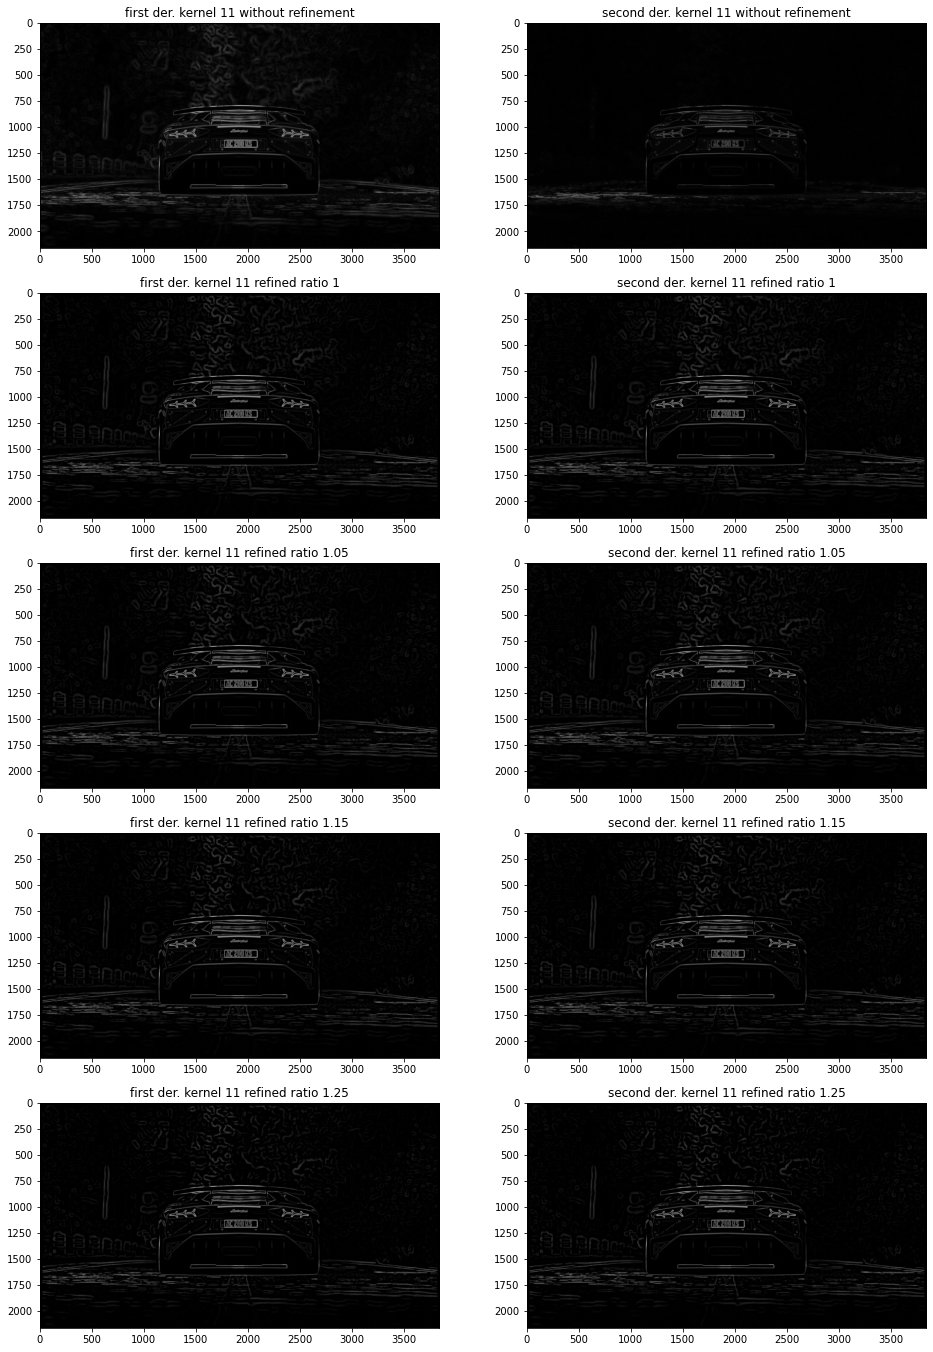

In [18]:
testRun(iiL4b, 11)

### Plotting all different refined edges ratios with kernel size 51

Calculating first and second derivatives of image for kernal size 51...
Finished image first and second derivatives (Done in 47143 ms)

Calculating first and second derivative integrals for kernal size 51...
Finished first derivative integeral (Done in 3982 ms)
Finished second derivative integeral (Done in 4267 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1...
Finished refined first derivative (Done in 15981 ms)
Finished refined second derivative (Done in 15802 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1.05...
Finished refined first derivative (Done in 16150 ms)
Finished refined second derivative (Done in 15764 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1.15...
Finished refined first derivative (Done in 15830 ms)
Finished refined second derivative (Done in 15653 ms)

Calculating refined first and second derivatives of kernal size 51 with ratio 1.25...
Finished refined 

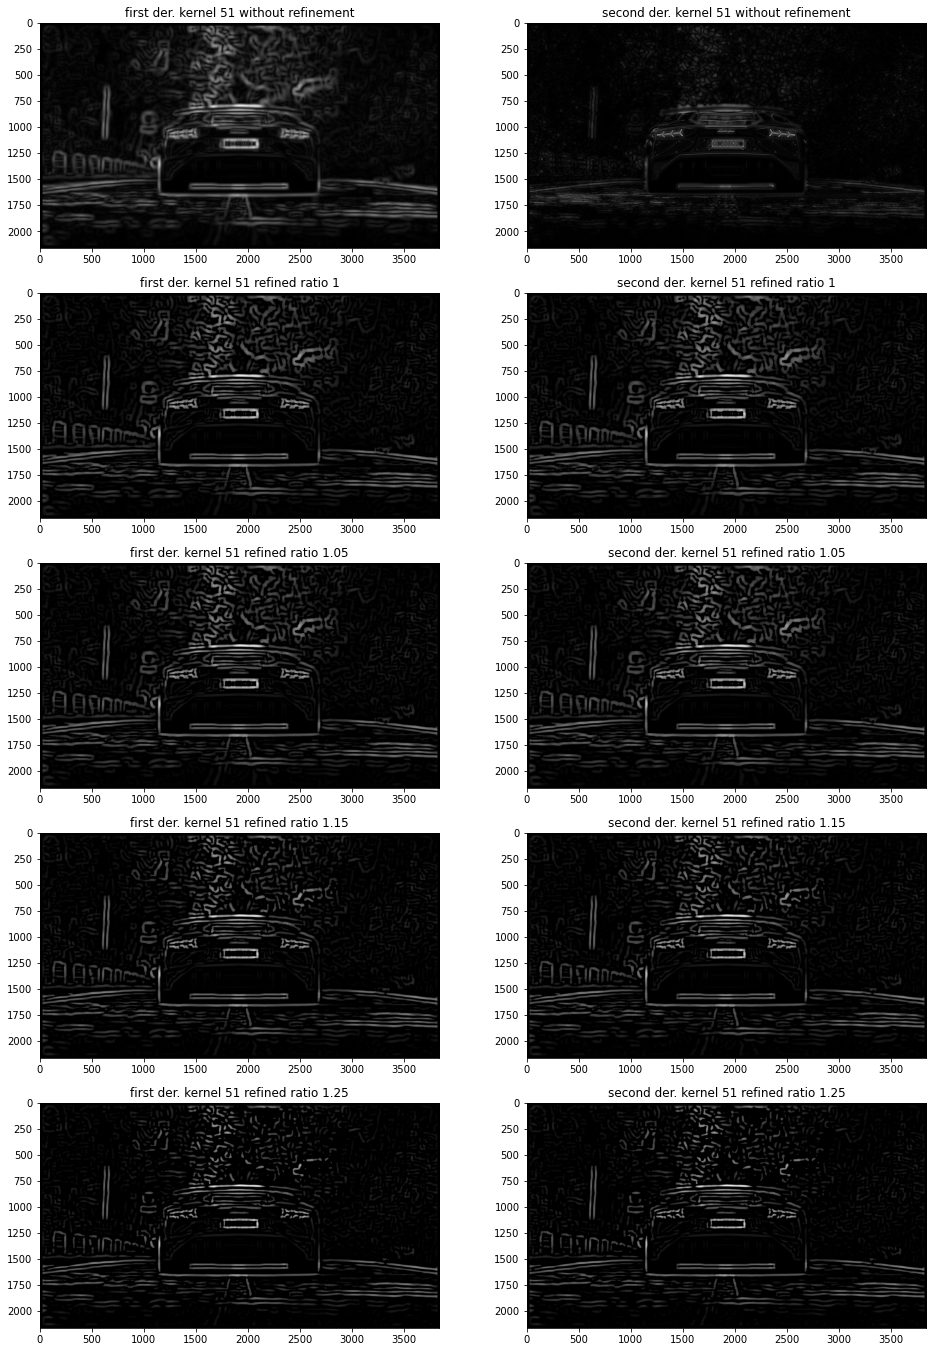

In [19]:
testRun(iiL4b, 51)

### Plotting all different refined edges ratios with kernel size 101

Calculating first and second derivatives of image for kernal size 101...
Finished image first and second derivatives (Done in 45990 ms)

Calculating first and second derivative integrals for kernal size 101...
Finished first derivative integeral (Done in 4030 ms)
Finished second derivative integeral (Done in 4286 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1...
Finished refined first derivative (Done in 15822 ms)
Finished refined second derivative (Done in 15857 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1.05...
Finished refined first derivative (Done in 15765 ms)
Finished refined second derivative (Done in 15885 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1.15...
Finished refined first derivative (Done in 15666 ms)
Finished refined second derivative (Done in 15920 ms)

Calculating refined first and second derivatives of kernal size 101 with ratio 1.25...
Finished re

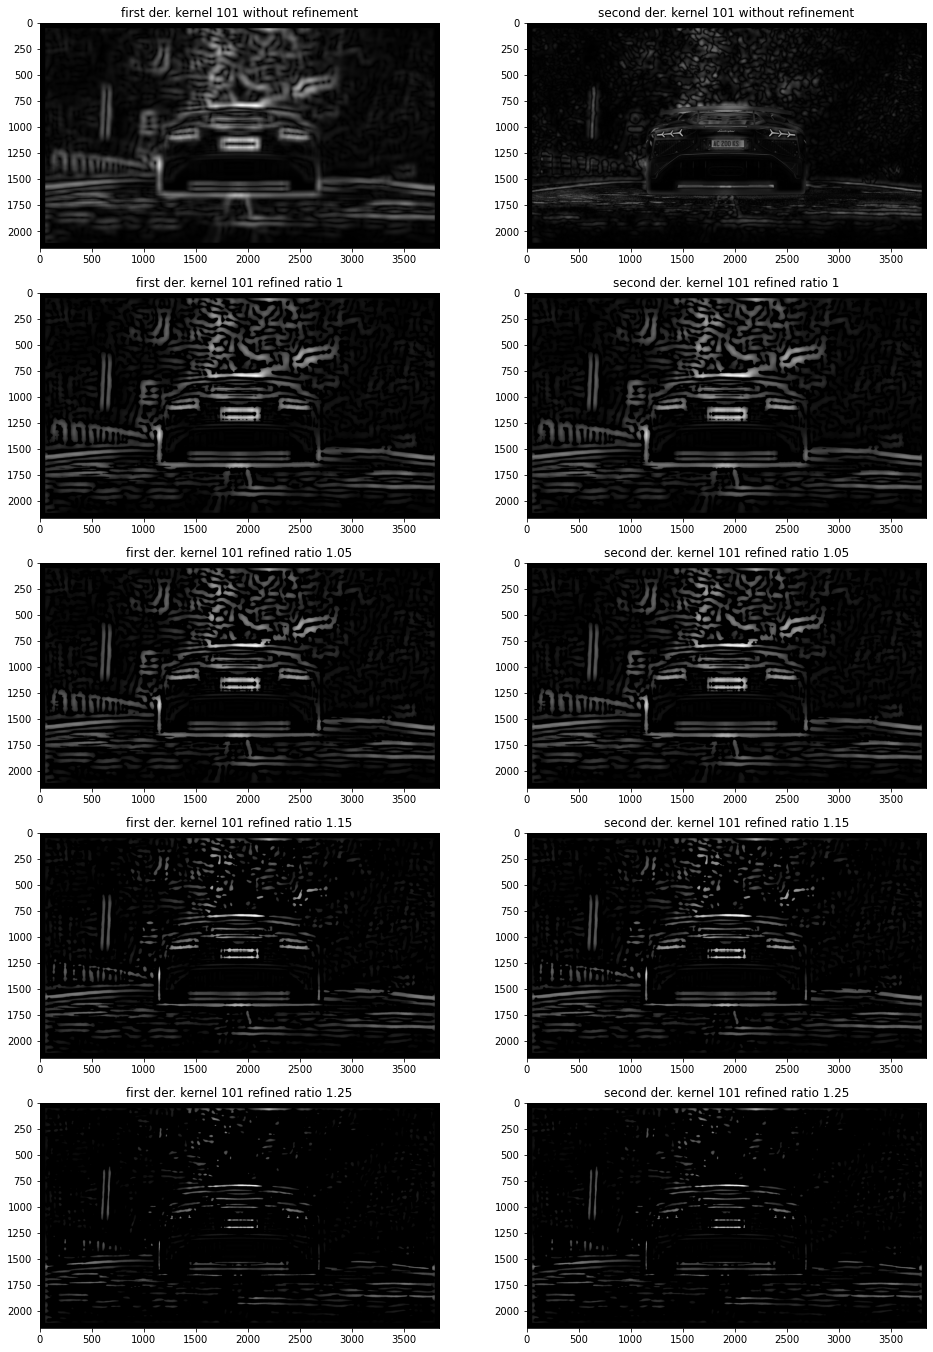

In [20]:
testRun(iiL4b, 101)

### Plotting all different refined edges ratios with kernel size 121

Calculating first and second derivatives of image for kernal size 121...
Finished image first and second derivatives (Done in 45468 ms)

Calculating first and second derivative integrals for kernal size 121...
Finished first derivative integeral (Done in 3983 ms)
Finished second derivative integeral (Done in 4271 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1...
Finished refined first derivative (Done in 16038 ms)
Finished refined second derivative (Done in 15899 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1.05...
Finished refined first derivative (Done in 15871 ms)
Finished refined second derivative (Done in 15811 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1.15...
Finished refined first derivative (Done in 15749 ms)
Finished refined second derivative (Done in 15612 ms)

Calculating refined first and second derivatives of kernal size 121 with ratio 1.25...
Finished re

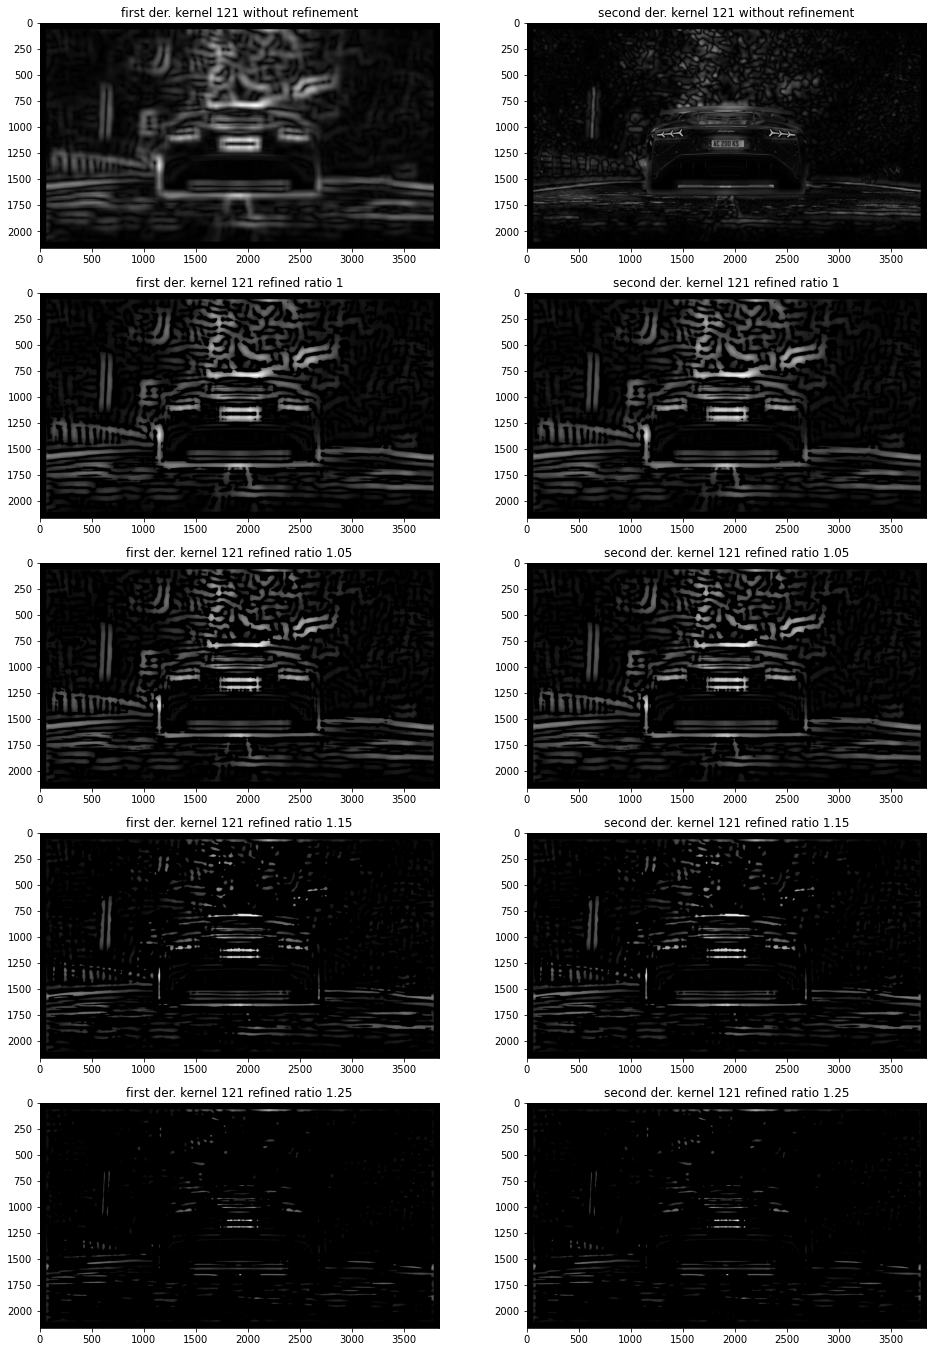

In [21]:
testRun(iiL4b, 121)

# Comparison between the derivatives of different kernel sizes

To find out the effect of the kernal size on the edge detection process, we will visualize the first and second derivatives of the first and second image using all kernal sizes. 

In [22]:
def compareKernalSizes(ii):
  kernalSizes = [11, 51, 101, 121]
  fig = plt.figure(figsize=(16, 16))
  rows = len(kernalSizes)
  columns = 2

  i = 1
  for s in kernalSizes:
    print(f'Calculating first and second derivatives of image for kernal size {s}...')
    d1, d2 = runWithStopwatch(EdgeDetect, [ii, s], 'Finished image first and second derivatives')
    print()

    fig.add_subplot(rows, columns, i)
    plt.title(f'first der. kernel {s}') 
    plt.imshow(d1, cmap="gray")

    fig.add_subplot(rows, columns, i + 1)
    plt.title(f'second der. kernel {s}') 
    plt.imshow(d2, cmap="gray")

    i += 2

  plt.show()

## L4 Plots

Calculating first and second derivatives of image for kernal size 11...
Finished image first and second derivatives (Done in 47346 ms)

Calculating first and second derivatives of image for kernal size 51...
Finished image first and second derivatives (Done in 47580 ms)

Calculating first and second derivatives of image for kernal size 101...
Finished image first and second derivatives (Done in 45883 ms)

Calculating first and second derivatives of image for kernal size 121...
Finished image first and second derivatives (Done in 45307 ms)



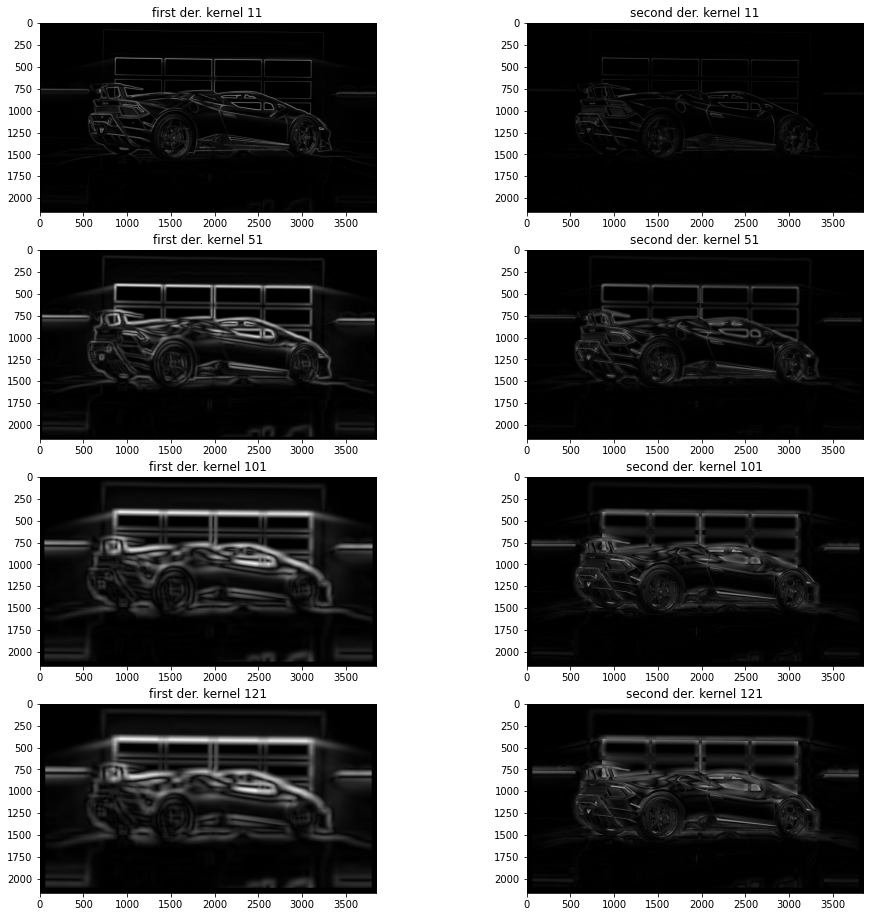

In [23]:
compareKernalSizes(iiL4)

## L4b Plots

Calculating first and second derivatives of image for kernal size 11...
Finished image first and second derivatives (Done in 47696 ms)

Calculating first and second derivatives of image for kernal size 51...
Finished image first and second derivatives (Done in 48042 ms)

Calculating first and second derivatives of image for kernal size 101...
Finished image first and second derivatives (Done in 46004 ms)

Calculating first and second derivatives of image for kernal size 121...
Finished image first and second derivatives (Done in 45486 ms)



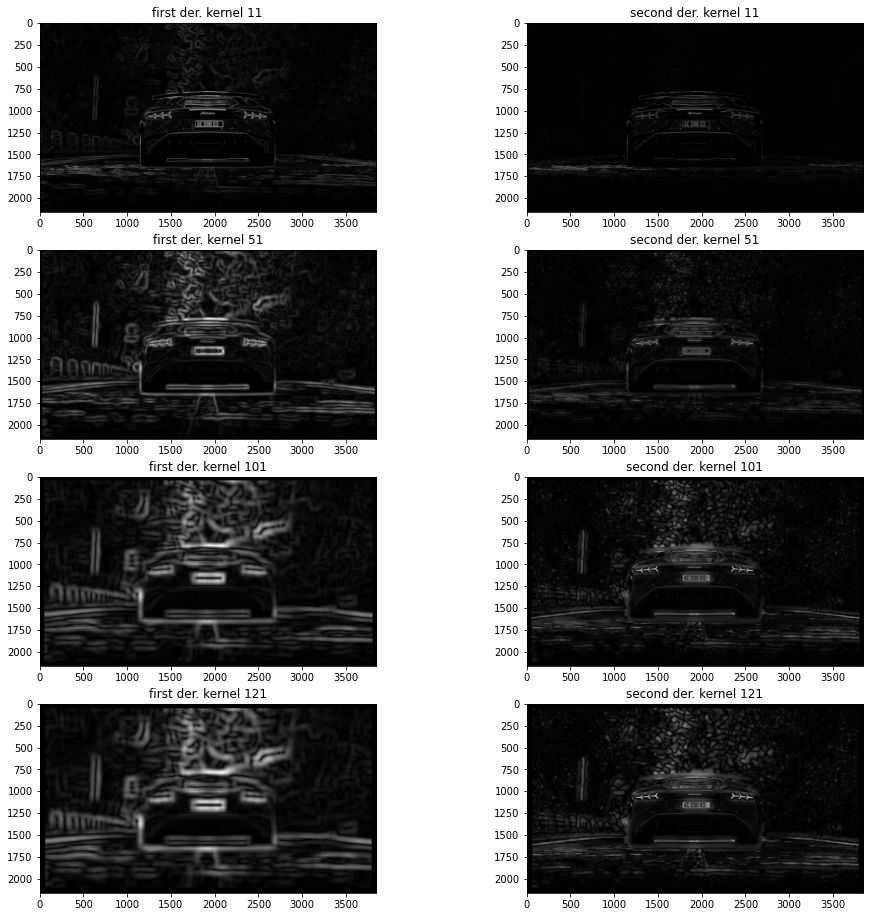

In [24]:
compareKernalSizes(iiL4b)

## Comment

After viewing the plots of both images, we can see that with the increase of the kernal size:
- More edges get detected.
- Previously detected edges get thicker.
- When edges gets thicker they get blurry with large kernal sizes (especially in first derivatives) and lose details.

## Observation
It is noticed that the quality of the edge detection using the kernel size of 51, resulted in high quality edges in terms of being visible and at the same time sharp and not blurry (espically with edge refinement).